**NLP Analysis - Reviews Data**

# Introduction

In the following notebook, I will be performing an NLP analysis of San Francisco Airbnb review data from December 2018 - December 2019.

My goal in this analysis is to find insights to answer the following questions:
- What are some things that hosts makes a positive user experience? What about a negative user experience? What are the commonalities among them within the review data?
- How would you advise a first time Airbnb host to ensure a great user experience? What are some goods/additional services a new host can provide to help ensure continued business on the Airbnb platform?

## Read in libraries, data, and set notebook preferences

**Read in libraries**

In [45]:
#Read in libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

**Read in data**

In [46]:
#Set path to data
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Air BnB - SF\Data\03_Processed'

#Read in data
df = pd.read_csv(path + '/2020_0208_Reviews_Processed_NLP.csv',sep=',',
                 parse_dates=['date'])

**Set preferences for notebook**

In [47]:
#Ignore warnings
import warnings; warnings.simplefilter('ignore')

#Increase number of columns and rows displayed by Pandas
pd.set_option('display.max_colwidth',500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',100)

#Set style for plots
plt.style.use('Solarize_Light2')

## Preview data

In [48]:
print('Reviews data shape:', df.shape)
display(df.head())

Reviews data shape: (120223, 5)


,comments,date,word_count,sentiment_compound,label
0,"Host was very friendly. The block where this Air BnB is, was fine, but Haight is still a bit unsavory.",2015-06-08,20,-0.5082,negative
1,"I have stayed in many airbnb, always met host, on arrival, questions answered etc,, that did not occur, and then lock issue, none complanied re the locks so then new locks placed, but arrived and noticed new lock , but no code given to us,, had to call host in late hours ,, all unnecessary hassle.",2016-06-26,56,-0.4215,negative
2,"Gabriels spot is small but great for the price & for a couple if your in town just for a couple nights. Quiet neighborhood up on the hill close enough to walk although I do suggest you take a car service home after cause some of those SF hills are brutal after a long day. Only thing that was kinda a bummer was the shower water pressure is non existent after a long day in the city. Overall though, nice small place to stay if you plan on being out in the city most of the time which you shou...",2016-01-26,107,-0.3297,negative
3,"Michael's place is nice and clean. Near to bus stop and railway stop. We didn't meet Michael in person because she was in her vacation, but the self check-in was very convenient. The only unperfect things are the noises from the street and the weak water pressure of the shower. Overall it's a good place to stay for people visiting San Francisco.",2017-05-26,62,-0.3071,negative
4,No kitchen supply,2019-11-17,3,-0.2960,negative


# Data Exploration

## Histogram of VADER sentiment scores

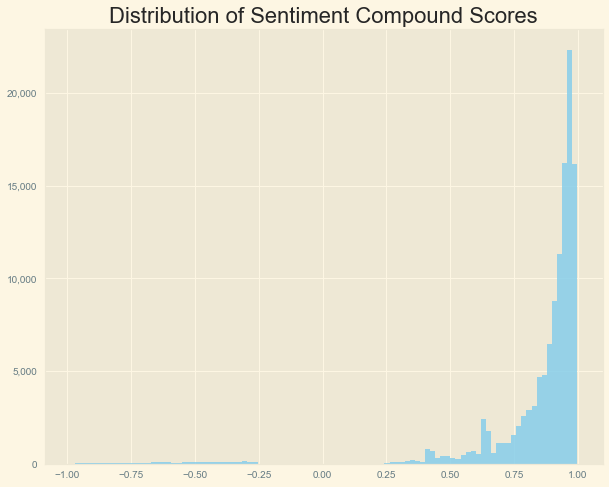

In [49]:
#Set plot
fig, ax = plt.subplots(figsize = (10,8))

#Plot hist of sentiment_compound scores
j = df.sentiment_compound.hist(ax = ax,bins = 100, color = 'skyblue', alpha = .85)

#Set plot aesthetics
j.set_title('Distribution of Sentiment Compound Scores', fontsize = 22)
ax.set_yticklabels(['{:,}'.format(int(y)) for y in ax.get_yticks()]);

## Positive and negative review counts

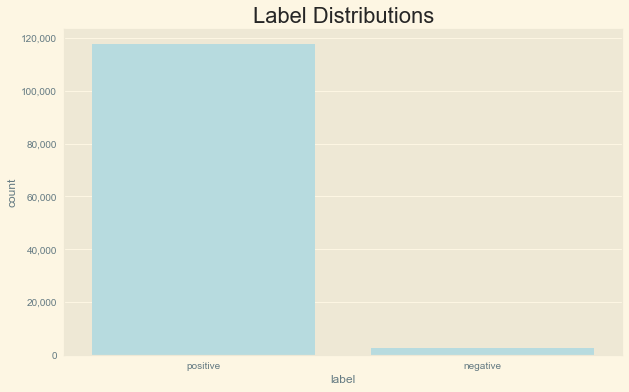

In [50]:
#Set plot
fig, ax = plt.subplots(figsize=(10,6))

#plot data
g =sns.countplot(x='label', data = df,order = ['positive', 'negative'], color='powderblue')

#Set plot aesthetics
g.set_title('Label Distributions', fontsize = 22)
g.set_yticklabels(['{:,}'.format(int(y)) for y in ax.get_yticks()]);

## Distribution of word counts for positive and negative reviews

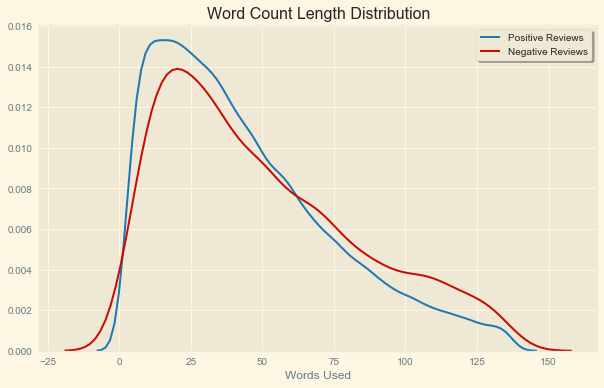

In [51]:
#Create pos/negative df's
pos_df = df[df.label == 'positive']
neg_df = df[df.label == 'negative']

#Create pos/neg corpora
pos_comments = pos_df['comments'].tolist()
neg_comments = neg_df['comments'].tolist()

#Set plot
fig, ax = plt.subplots(figsize=(10,6))

#Plot Histograms for word count
sns.distplot(pos_df.word_count, kde = True, hist = False, color = 'tab:blue', ax=ax, label = 'Positive Reviews')
sns.distplot(neg_df.word_count, kde = True, hist = False, color = 'r', ax=ax, label='Negative Reviews')

#Set plot aesthetics
ax.legend(shadow = True, frameon = True);
ax.set_title('Word Count Length Distribution')
ax.set_xlabel('Words Used');

## Word clouds and frequency counts of positive and negative reviews

In [52]:
#Import wordcloud libraries 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

#Import stopwords
from nltk.corpus import stopwords, wordnet
stop_words = stopwords.words('english')

#Add additional stop words
stop_words.extend(['airbnb','website hidden by airbnb'])

#Import libraries for word count visualization
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text.freqdist import FreqDistVisualizer

### Postive Reviews 

**WordCloud**

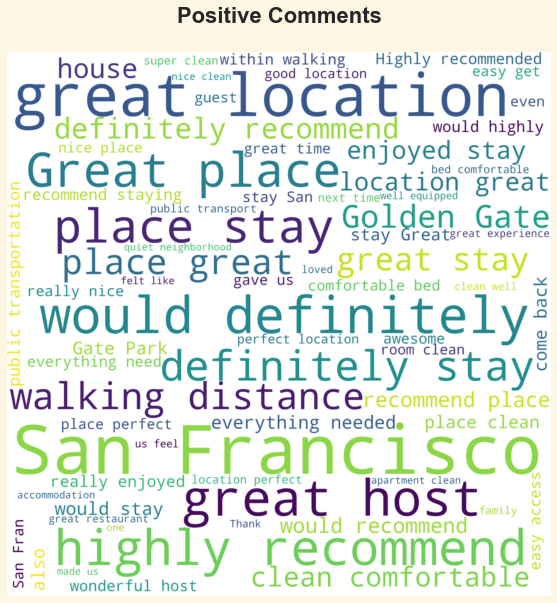

In [53]:
#Create wordcloud for postive reviews
wordcloud = WordCloud(max_font_size=500, max_words=70, background_color="white", stopwords=stop_words,
                      width= 4000, height = 4000).generate(str(pos_comments))

#Plot data and set plot aesthetics
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.title('Positive Comments\n', fontsize=22, fontweight='bold')
plt.show()

**Positive Word Frequency Distributions**

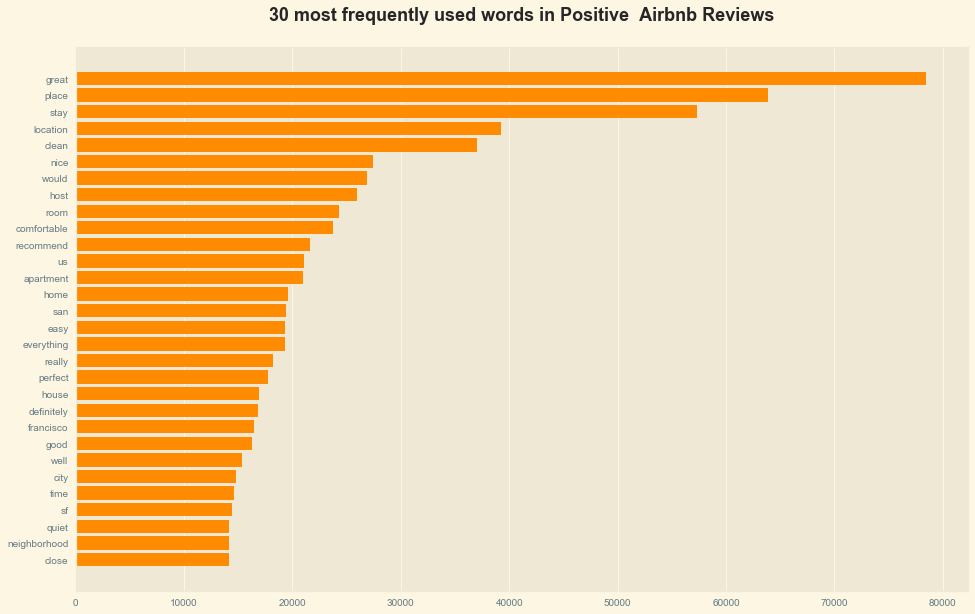

In [54]:
#Vectorize comments and also remove stop words
cv = CountVectorizer(stop_words=stop_words)
positive_docs = cv.fit_transform(pos_comments)
features = cv.get_feature_names()

#Preparing the plot
plt.figure(figsize=(16,10))
plt.title('30 most frequently used words in Positive  Airbnb Reviews\n', fontsize = 18, fontweight='bold')

# instantiating and fitting the FreqDistVisualizer, plotting the top 30 most frequent terms
visualizer = FreqDistVisualizer(features=features, n=30, orient='h', color = 'darkorange')
visualizer.fit(positive_docs)
visualizer.poof;

### Negative Reviews

**WordCloud**

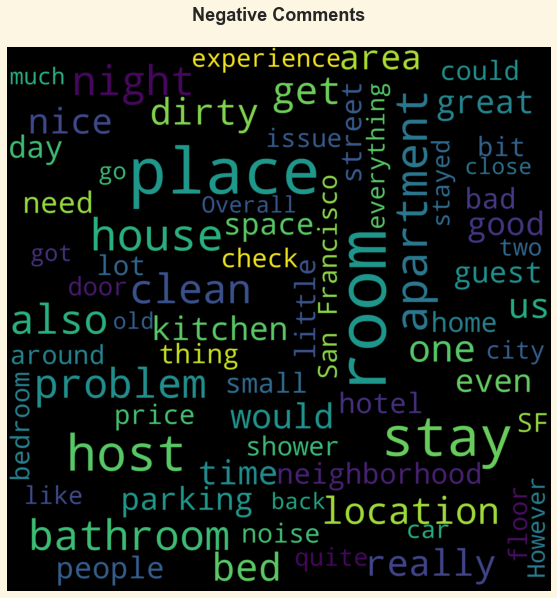

In [55]:
#Create wordcloud for postive reviews
wordcloud = WordCloud(max_font_size=500, max_words=70, background_color="black",stopwords=stop_words,
                      width= 4000, height = 4000).generate(str(neg_comments))

#Plot data and set plot aesthetics
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.title('Negative Comments\n', fontsize=18, fontweight='bold')
plt.show()

**Negative Word Frequency Distributions**

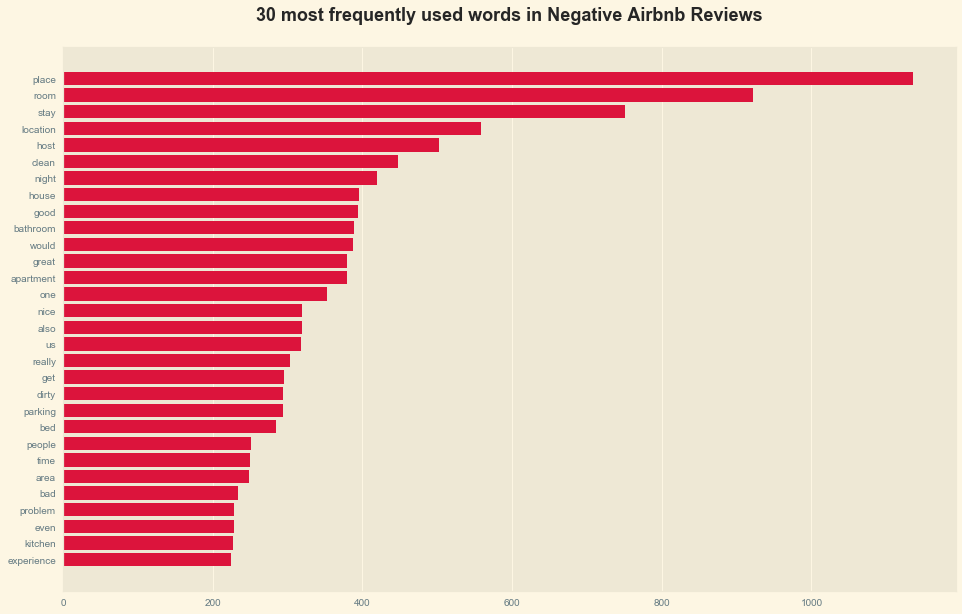

In [56]:
#Vectorize comments and also remove stop words
cv = CountVectorizer(stop_words=stop_words)
negative_docs = cv.fit_transform(neg_comments)
features = cv.get_feature_names()

#Preparing the plot
plt.figure(figsize=(16,10))
plt.title('30 most frequently used words in Negative Airbnb Reviews\n', fontsize = 18, fontweight='bold')

# instantiating and fitting the FreqDistVisualizer, plotting the top 30 most frequent terms
visualizer = FreqDistVisualizer(features=features, n=30, orient='h',color='crimson')
visualizer.fit(negative_docs)
visualizer.poof;

# Topic Modeling for Positive Reviews

## Import libraries

In [57]:
# Gensim
import gensim
from gensim import models
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Import spacy for lemmatization
from spacy.lang.en import English
import spacy
import en_core_web_lg
nlp = en_core_web_lg.load()

#Reg exp
import re

#LDA model plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt

## Data Preparation

### Functions for data cleaning, tokenization, and lemmatization

In [58]:
#Raw data tokenizer/simple processor 
def tokenizer(raw_reviews):
    """
    Takes raw text data.
    Yields a tokenized version of raw data w/ punctuation removed and all characters in lowercase
    """
    for review in raw_reviews:
        yield(gensim.utils.simple_preprocess(review, deacc=True))
        
#Clean up raw tokens
def remove_stopwords(tokens):
    """
    Remove stopwords and words < 3 characters in length from tokenized comments
    """
    tokens = [tokens.remove(token) if len(token) <3 else token for token in tokens] 
    tokens = [token for token in tokens if token] #Remove None from tokens
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in tokens]

#Lemmatize cleaned tokens
def lemmatization(cleaned_tokens, pos_tags = ['NOUN', 'ADJ', 'VERB', 'ADV']):
    """
    Lemmatize CLEANED tokens with specified pos tags and append to lemmatized_text. 
    Default pos_tags = ['NOUN', 'ADJ', 'VERB', 'ADV'] 
    """
    for item in cleaned_tokens:
        doc = nlp(" ".join(item))
        lemmatized_text.append([token.lemma_ for token in doc if token.pos_ in pos_tags])
    return lemmatized_text

#Create bigrams
def bigrams(tokens):
    return[bigram_mod[token] for token in tokens]

#Create trigrams
def trigrams(tokens):
    return[trigram_mod[bigram_mod[token]] for token in tokens]

### Clean-up raw data. Create bi & trigrams

**Tokenize raw comments**

In [59]:
#Tokenize pos_comments and remove puncuation
pos_tokens = list(tokenizer(pos_comments))

**Create bigram and trigram models**

In [60]:
#Build bigram and trigram models
bigram = gensim.models.Phrases(pos_tokens,min_count=20, threshold=100)#Might need to increse with full data set
trigram = gensim.models.Phrases(bigram[pos_tokens], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

Remove stopwords, create trigrams, and lemmatize

In [61]:
#Remove stopwords from pos_tokens
pos_tokens_clean = remove_stopwords(pos_tokens)

#Create trigrams from cleaned tokens
pos_trigrams = trigrams(pos_tokens_clean)

#Init spacy 'en' model keeping only tagger component 
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])

#Init empty list to append lemmatized tokens to
lemmatized_text = []

#Lemmatize noun, adj, vb, adv
data_lemmatized = lemmatization(list(pos_trigrams),pos_tags = ['NOUN', 'ADJ', 'VERB', 'ADV'])

#Check
print(data_lemmatized[0])

['enjoy', 'stay', 'apartment', 'location', 'perfect', 'job', 'interview', 'couple', 'block', 'away', 'go', 'apartment', 'really', 'tastefully_furnishe', 'look', 'exactly', 'picture', 'definitely', 'recommend', 'stay']


### Create Bag of Words and normalize with TF-IDF

**Create bow_corpus**

In [62]:
#Create dictionary of words from lemmatized data
dictionary = corpora.Dictionary(documents=data_lemmatized)

#Filter dictionary and remove words that apppear in < 15 documents and in more than 50% of the documents
dictionary.filter_extremes(no_below=15, no_above=0.5)

#Create BoW and view # of unique words
bow_corpus = [dictionary.doc2bow(text) for text in data_lemmatized]
print('Number of unique words in dictionary for positive reviews:', len(dictionary))

#Preview Bag Of Words
bow_doc_1 = bow_corpus[0]
for i in range(len(bow_doc_1)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_1[i][0], 
                                               dictionary[bow_doc_1[i][0]], bow_doc_1[i][1]))

Number of unique words in dictionary for positive reviews: 3411
Word 0 ("apartment") appears 2 time.
Word 1 ("away") appears 1 time.
Word 2 ("block") appears 1 time.
Word 3 ("couple") appears 1 time.
Word 4 ("definitely") appears 1 time.
Word 5 ("enjoy") appears 1 time.
Word 6 ("exactly") appears 1 time.
Word 7 ("go") appears 1 time.
Word 8 ("interview") appears 1 time.
Word 9 ("job") appears 1 time.
Word 10 ("location") appears 1 time.
Word 11 ("look") appears 1 time.
Word 12 ("perfect") appears 1 time.
Word 13 ("picture") appears 1 time.
Word 14 ("really") appears 1 time.
Word 15 ("recommend") appears 1 time.
Word 16 ("stay") appears 2 time.
Word 17 ("tastefully_furnishe") appears 1 time.


**Compute term frequency in bow_corpus and normalize w/ TF-IDF**

In [63]:
#Init TfidfModel
tfidf = models.TfidfModel(bow_corpus)

#Transform bow_corpus with tfidf
corpus_tfidf = tfidf[bow_corpus]

#Check first document
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.24476878840544655),
 (1, 0.1761081867864935),
 (2, 0.20559887557234277),
 (3, 0.22378216642046475),
 (4, 0.11660896193586918),
 (5, 0.1446653237236509),
 (6, 0.20026774069384434),
 (7, 0.15678537516694332),
 (8, 0.45246669419848007),
 (9, 0.34077791125049806),
 (10, 0.06804701354699179),
 (11, 0.18442643002167466),
 (12, 0.1248181092468052),
 (13, 0.21843189878317545),
 (14, 0.12163060305879686),
 (15, 0.09111194103072287),
 (16, 0.09194840070777338),
 (17, 0.5130001096610908)]


## Topic Modeling with LDA

### Find optimal number of topics using coherence score

In [64]:
#Get coherence scores 
def get_coherence_values(dictionary, corpus, texts, max_topics, start=2, step=3):
    """
    Compute the coherence score for different LDA models
    of different topic numbers
    ----------------------------------------------------
    PARAMETERS:
    - dictionary : Gensim dictionary
    - corpus : Gensim corpus
    - texts : List of input texts
    - limit : Max num of topics 
    """
    coherence_scores = []
    model_list = []
    for topics in range(start, max_topics, step):
        model = gensim.models.LdaMulticore(corpus = corpus, num_topics=topics,workers=3, id2word=dictionary, random_state=24)
        model_list.append(model)
        coherence_model = CoherenceModel(model = model, texts=texts, dictionary=dictionary)
        coherence_scores.append(coherence_model.get_coherence())
    return model_list, coherence_scores

Coherence Score for LDA w/ 2 topics: 0.363
Coherence Score for LDA w/ 4 topics: 0.399
Coherence Score for LDA w/ 6 topics: 0.394
Coherence Score for LDA w/ 8 topics: 0.387
Coherence Score for LDA w/ 10 topics: 0.393
Coherence Score for LDA w/ 12 topics: 0.382
Coherence Score for LDA w/ 14 topics: 0.38
Coherence Score for LDA w/ 16 topics: 0.375
Coherence Score for LDA w/ 18 topics: 0.367


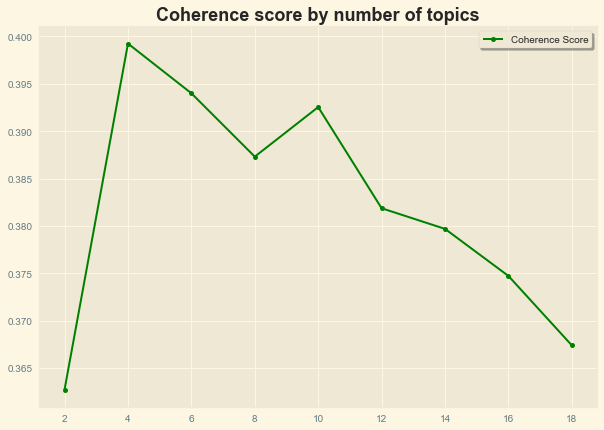

In [65]:
#Set parameters for topic count in _coherence_values
start=2; max_topics=20; step=2;

#Init coherenc scores for LDA model with a max of 20 topics
models, scores = get_coherence_values(dictionary=dictionary, corpus=corpus_tfidf, 
                                                    texts=data_lemmatized, start=start, max_topics=max_topics, step=step)

#Create list of topic counts to view/visualize coherence scores 
x= list(range(start, max_topics, step))

#Print coherence scores
for m, cv in zip(x, scores):
    print('Coherence Score for LDA w/', m,'topics:', round(cv,3))

#Set plot size
plt.figure(figsize=(10,7))

#Plot coherence scores
plt.plot(x,scores, label = 'Coherence Score', color='green', marker='o', linestyle='-',
      linewidth=2, markersize=5, )

plt.title('Coherence score by number of topics', fontsize = 18, fontweight='bold')
plt.legend(frameon = True, shadow = True)
plt.show();

### Build optimal LDA model, calculate model perplexity and visualize topics

In [67]:
#Init optimal model with the optimal number of topics(8 topics)
optimal_model = gensim.models.LdaMulticore(corpus=corpus_tfidf,id2word=dictionary,
                                           num_topics=4, random_state=24,
                                           passes=10)

#Save optimal model
optimal_model.save('Positive_Reviews_LDA.model')

#Compute LDA model perplexity
print('Optimal LDA Model Perplexity: ', optimal_model.log_perplexity(corpus_tfidf))

# Compute Coherence Score
from gensim.models import CoherenceModel
optimal_model_coherence = CoherenceModel(model=optimal_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
print('\nOptimal LDA Model Coherence Score: ', optimal_model_coherence.get_coherence())

#View 8 topics
print('\nOptimal LDA Model Topics:')
display(optimal_model.print_topics())

Optimal LDA Model Perplexity:  -7.228256663769791

Optimal LDA Model Coherence Score:  0.4440482453016534

Optimal LDA Model Topics:


[(0,
  '0.011*"home" + 0.010*"make" + 0.009*"stay" + 0.008*"feel" + 0.008*"host" + 0.007*"place" + 0.007*"welcome" + 0.006*"beautiful" + 0.006*"experience" + 0.006*"time"'),
 (1,
  '0.031*"great" + 0.024*"location" + 0.023*"place" + 0.021*"host" + 0.020*"stay" + 0.018*"clean" + 0.018*"nice" + 0.017*"recommend" + 0.015*"would" + 0.013*"highly"'),
 (2,
  '0.009*"room" + 0.007*"check" + 0.007*"place" + 0.006*"nice" + 0.006*"great" + 0.006*"stay" + 0.006*"good" + 0.005*"really" + 0.005*"night" + 0.005*"clean"'),
 (3,
  '0.010*"walk" + 0.009*"restaurant" + 0.008*"close" + 0.007*"parking" + 0.007*"great" + 0.007*"easy" + 0.007*"distance" + 0.006*"park" + 0.006*"nice" + 0.006*"room"')]

In [68]:
#Visulize topics from LDA model for positive reviews
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus_tfidf, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.066334 -0.079485       1        1  32.533737
0     -0.018193  0.104646       2        1  24.900665
1     -0.145145 -0.039716       3        1  23.332081
2      0.097004  0.014554       4        1  19.233517, topic_info=            Term         Freq        Total Category  logprob  loglift
20         great  4896.000000  4896.000000  Default  30.0000  30.0000
10      location  3827.000000  3827.000000  Default  29.0000  29.0000
41          host  3462.000000  3462.000000  Default  28.0000  28.0000
48         place  4216.000000  4216.000000  Default  27.0000  27.0000
15     recommend  2878.000000  2878.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
10      location   376.170471  3827.548340   Topic4  -5.3417  -0.6714
41          host   328.936249  3462.594971   Topic4  -5.4758  -0.7054
57         would   317.239380  2883.351562   Topic4  -5.5120  -0.5585
33   comfortable   313.472595  2754.163574   Topic4  -5.5240  -0.5246
162         need   305.217590  2128.609863   Topic4  -5.5507  -0.2937

[363 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1977      1  0.011029  absolute
1977      2  0.981586  absolute
262       1  0.560288    access
262       2  0.059325    access
262       3  0.296623    access
...     ...       ...       ...
57        2  0.200461     would
57        3  0.510864     would
57        4  0.109942     would
2065      1  0.029274     wrong
2065      2  0.966050     wrong

[754 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3])

### Additional insights into topics

**Find dominant topic for each review and view topic distribution in positive reviews**

In [100]:
#Write function that assigns topic to each 
def topic_finder(ldamodel, corpus, text):
    """
    Returns dataframe containing dominant topic 
    for each individual review
    """
    topics = pd.DataFrame()
    
    #Get main topic of each doc
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key = lambda x: (x[1]), reverse = True)
    #Get the dominant topic, percent contribution, and keywords for each document
        for j,(topic_num, prop_topic) in enumerate(row):
            if j == 0: #Dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                topics = topics.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    #Rename columns
    topics.columns = ['Dominant_Topic', 'Percent_Contribution', 'Topic_Keywords']
    #Append original comments to pos_topics
    comments = pd.Series(text)
    topics = pd.concat([topics, comments], axis = 1)
    return topics   

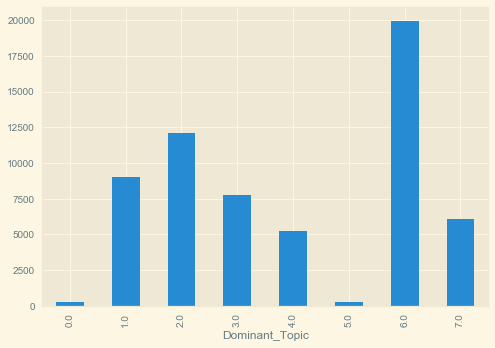

In [101]:
#Find dominant topic for each review
positive_topics = topic_finder(optimal_model,corpus_tfidf, pos_comments)

#Format positive_topics
positive_topics.columns = ['Dominant_Topic', 'Topic%_Contribution','Keywords', 'Reviews']

#View distribution of topics across all positive reviews
positive_topics.groupby('Dominant_Topic')['Dominant_Topic'].count().plot(kind = 'bar')

**Extract 3 most representative documents for each positive topic**

In [102]:
#Subset 3 largest topic contributors per topic and get index
top_docs = positive_topics.groupby('Dominant_Topic')['Topic%_Contribution'].nlargest(3).reset_index()
rows = list(top_docs['level_1'])

#View comments that contribute the most to each topic
positive_topics.iloc[(rows)]

,Dominant_Topic,Topic%_Contribution,Keywords,Reviews
56731,0.0,0.6835,"advertise, instruction, accommodating, simple, possible, fan, quaint, golden_gate_bridge, request, clear",Amy was easy to communicate with and the space was spotless!
42244,0.0,0.6772,"advertise, instruction, accommodating, simple, possible, fan, quaint, golden_gate_bridge, request, clear",Very nice clean home. Perfect for families.
28559,0.0,0.6768,"advertise, instruction, accommodating, simple, possible, fan, quaint, golden_gate_bridge, request, clear","Everything at Andrew's place was as expected - clean, comfortable, and reliable wifi. Worked great for a quick overnight while in town for business. Did not get a chance to connect in person with Andrew, but he was very responsive over messaging."
48841,1.0,0.8619,"home, stay, host, time, great, back, place, make, thank, would","Super clean, nice hosts, nothing to complain."
54454,1.0,0.8575,"home, stay, host, time, great, back, place, make, thank, would","Overall, very enjoyable experience. Pros: Lindsay and Brian are both very nice. They left a helpful guidebook with multiple maps/pamphlets and Lindsay provided in person suggestions upon arrival. They leave a lovely bottle of wine for guests. The room is spacious with a very comfortable bed. The neighbourhood is a short walk to Baker Beach, which is beautiful. The neighbourhood is great, with many good food options (try Angelina's Cafe for sandwiches) as well as grocery stores and a movie th..."
2444,1.0,0.8555,"home, stay, host, time, great, back, place, make, thank, would","It was a wonderful stay! They were so kind, left us a basket of goodies and a bottle of wine to greet us and even baked us cookies. It was a great choice for our honeymoon!"
17992,2.0,0.8474,"great, location, place, host, nice, clean, stay, recommend, good, comfortable","Rahul's place was an awesome experience. Extremely clean and an amazing location that allows you to see the real San Francisco. Rahul was one of the most attentive and thoughtful hosts I've ever had. Also, his dog Monster is so sweet (I wanted to take him with me but couldn't for obvious legal/judicial reasons). Thank you so much for allowing me to stay in your beautiful home! Hands down one of the best Airbnbs I've ever stayed in anywhere."
47447,2.0,0.8472,"great, location, place, host, nice, clean, stay, recommend, good, comfortable",Had a real blast in San Francisco. Great Stay with Zain & Duncan.
47814,2.0,0.8472,"great, location, place, host, nice, clean, stay, recommend, good, comfortable","There was such style and charm in the house, my guests were very impressed with the decor. It had a lot of character and definitely an artsy SF vibe. Celia's assistant was also very responsive and provided cleaning for the house mid stay and came over when the dishwasher was broken. All in all, I would definitely recommend a stay at this house!"
8866,3.0,0.8652,"restaurant, walk, close, distance, great, shop, public, transportation, park, easy",its nice place.. nice people.. high value


# Negative Reviews

## Data preparation

**Tokenize raw comments**

In [103]:
#Tokenize negative raw comments
neg_tokens = list(tokenizer(neg_comments))

**Create bigram and trigram models**

In [104]:
#Build bigram and trigram models on neg_tokens
bigram = gensim.models.Phrases(neg_tokens,min_count=5, threshold=10)
trigram = gensim.models.Phrases(bigram[neg_tokens], threshold=10)

#Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

**Remove stopwords from neg tokens, create trigrams, and lemmatize**

In [105]:
#Remove stopwords
neg_tokens_cleaned = remove_stopwords(neg_tokens)

#Create trigrams
neg_trigrams = trigrams(neg_tokens_cleaned)


#Initialize spacy 'en' model keeping only tagger component 
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])

#Init empty list to append lemmatized tokens to 
lemmatized_text = []

#Lemmatize neg_trigrams keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(list(neg_trigrams),pos_tags = ['NOUN', 'ADJ', 'VERB', 'ADV'])

#Check
print((data_lemmatized[1]))

['location', 'great', 'great', 'view', 'dirty', 'first_thing', 'anywhere', 'pull', 'back', 'bunch', 'crunchy', 'thing', 'hair', 'sheet', 'pillow', 'case', 'tear', 'several', 'place', 'pillow', 'case', 'hole', 'change', 'place', 'stay', 'brush', 'spend', 'uncomfortable', 'night', 'house', 'bathtub', 'shower', 'dirty', 'black', 'mold', 'meet', 'tub', 'sink', 'dirty', 'mean', 'clean', 'long_time', 'toilet', 'filthy', 'little', 'plastic', 'container', 'put', 'bathroom', 'stuff', 'counter', 'gross', 'would_never', 'put', 'toothpaste', 'toothbrush', 'heat', 'house', 'degree', 'night', 'go', 'purchase', 'small', 'heater', 'use', 'night', 'stay', 'offer', 'coffee', 'wake', 'go', 'kitchen', 'barely', 'cup', 'leave', 'machine', 'person', 'house', 'guess', 'quarter', 'pot', 'share', 'owner', 'get', 'disappoint', 'stay', 'recommend']


## Create Bag of Words and normalize with TF-IDF

**Create bow_corpus**

In [106]:
#Create dictionary of terms from data_lemmatized
dictionary = corpora.Dictionary(documents=data_lemmatized)

#Filter dictionary and remove tokens that apppear in <15 documents or are in more than 50% of the documents
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

#How many unique words are in our dictionary for negative reviews?
print('Number of unique words in dictionary for negative reviews:', len(dictionary))

#Init bow_corpus and view the number of unique words
bow_corpus = [dictionary.doc2bow(text) for text in data_lemmatized]


#Preview Bag Of Words for our sample preprocessed document.
bow_doc_1 = bow_corpus[1]
for i in range(len(bow_doc_1)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_1[i][0], 
                                               dictionary[bow_doc_1[i][0]], bow_doc_1[i][1]))

Number of unique words in dictionary for negative reviews: 1041
Word 11 ("change") appears 1 time.
Word 41 ("get") appears 1 time.
Word 43 ("go") appears 2 time.
Word 51 ("leave") appears 1 time.
Word 54 ("meet") appears 1 time.
Word 58 ("offer") appears 1 time.
Word 61 ("place") appears 2 time.
Word 69 ("sheet") appears 1 time.
Word 70 ("shower") appears 1 time.
Word 76 ("stay") appears 3 time.
Word 80 ("thing") appears 1 time.
Word 87 ("use") appears 1 time.
Word 93 ("anywhere") appears 1 time.
Word 94 ("back") appears 1 time.
Word 95 ("barely") appears 1 time.
Word 96 ("bathroom") appears 1 time.
Word 97 ("bathtub") appears 1 time.
Word 98 ("black") appears 1 time.
Word 99 ("bunch") appears 1 time.
Word 100 ("case") appears 2 time.
Word 101 ("clean") appears 1 time.
Word 102 ("coffee") appears 1 time.
Word 103 ("counter") appears 1 time.
Word 104 ("cup") appears 1 time.
Word 105 ("dirty") appears 3 time.
Word 106 ("disappoint") appears 1 time.
Word 107 ("filthy") appears 1 time.
Wor

**Compute term frequency in bow_corpus and normalize w/ TF-IDF**

In [107]:
#Init TfidfModel
from gensim import models
tfidf = models.TfidfModel(bow_corpus)

#Transform bow_corpus
corpus_tfidf = tfidf[bow_corpus]

#Check
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc[0:5])
    break

[(0, 0.06808273672420555),
 (1, 0.08370805824987969),
 (2, 0.20028326635652682),
 (3, 0.20325062393903745),
 (4, 0.0659363476125411)]


## Topic Modeling with LDA

### Find optimal Number of topics using coherence score

Coherence Score for LDA w/ 2 topics: 0.337
Coherence Score for LDA w/ 4 topics: 0.325
Coherence Score for LDA w/ 6 topics: 0.339
Coherence Score for LDA w/ 8 topics: 0.33
Coherence Score for LDA w/ 10 topics: 0.342
Coherence Score for LDA w/ 12 topics: 0.338
Coherence Score for LDA w/ 14 topics: 0.332
Coherence Score for LDA w/ 16 topics: 0.333
Coherence Score for LDA w/ 18 topics: 0.318


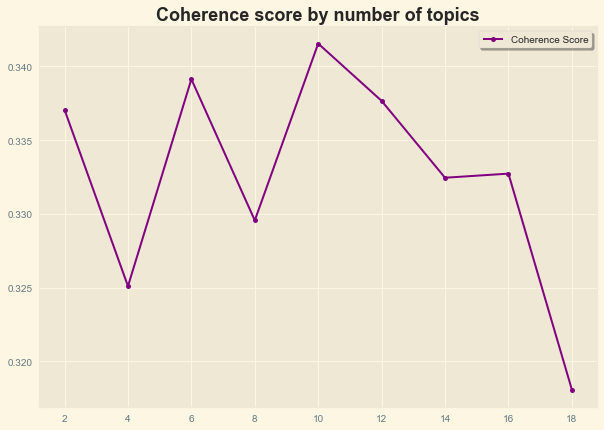

In [108]:
#Set parameters for get_coherence_values and visualization
start=2; max_topics=20; step=2;

models, scores = get_coherence_values(dictionary=dictionary, corpus=corpus_tfidf, 
                                                    texts=data_lemmatized, start=start, max_topics=max_topics, step=step)

#Set range for xaxis in visual
x= list(range(start, max_topics, step))

#Print coherence scores
for m, cv in zip(x, scores):
    print('Coherence Score for LDA w/', m,'topics:', round(cv,3))

#Set plot size
plt.figure(figsize=(10,7))

#Plot coherence scores
plt.plot(x,scores, label = 'Coherence Score', color='purple', marker='o', linestyle='-',
      linewidth=2, markersize=5, )

plt.title('Coherence score by number of topics', fontsize = 18, fontweight='bold')
plt.legend(frameon = True, shadow = True)
plt.show();

### Build optimal LDA model, calculate model perplexity and visualize topics

In [109]:
#Init optimal model with 10 topics
optimal_model =  gensim.models.LdaMulticore(corpus=corpus_tfidf,id2word=dictionary,
                                           num_topics=10, random_state=24,
                                       chunksize=100,passes=100)

#Save optimal model
optimal_model.save('Negative_Reviews_LDA.model')

#Compute LDA model perplexity
print('Optimal LDA Model Perplexity: ', optimal_model.log_perplexity(corpus_tfidf))

# Compute Coherence Score
from gensim.models import CoherenceModel
optimal_model_coherence = CoherenceModel(model=optimal_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
print('\nOptimal LDA Model Coherence Score: ', optimal_model_coherence.get_coherence())

#View topics
print('\nOptimal LDA Model Topics:')
display(optimal_model.print_topics())

Optimal LDA Model Perplexity:  -7.866953206117284

Optimal LDA Model Coherence Score:  0.38785314715435387

Optimal LDA Model Topics:


[(0,
  '0.043*"well" + 0.028*"great_location" + 0.026*"incredible" + 0.025*"price" + 0.025*"location" + 0.023*"place" + 0.020*"amazing" + 0.019*"convenient_location" + 0.015*"hassle" + 0.014*"budget"'),
 (1,
  '0.056*"place" + 0.049*"crash" + 0.043*"bad" + 0.041*"dirty" + 0.032*"cool" + 0.027*"stay" + 0.026*"fantastic" + 0.025*"advertise" + 0.020*"care" + 0.017*"name"'),
 (2,
  '0.042*"good" + 0.037*"great" + 0.033*"describe" + 0.026*"ready" + 0.024*"stay" + 0.023*"better" + 0.022*"worry" + 0.021*"neighborhood" + 0.020*"exactly" + 0.018*"complain"'),
 (3,
  '0.015*"parking" + 0.010*"close" + 0.010*"street" + 0.009*"great" + 0.009*"block" + 0.008*"restaurant" + 0.008*"location" + 0.008*"convenient" + 0.008*"car" + 0.008*"park"'),
 (4,
  '0.027*"disappoint" + 0.026*"terrible" + 0.024*"always" + 0.021*"kitchen" + 0.020*"regret" + 0.019*"refrigerator" + 0.019*"fill" + 0.018*"clothe" + 0.017*"dollar" + 0.016*"expect"'),
 (5,
  '0.042*"complaint" + 0.039*"wonderful" + 0.031*"responsive" + 0.

In [110]:
#Init pyCreate plot
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus_tfidf, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.021350  0.048317       1        1  63.323696
3      0.133441 -0.075105       2        1  15.054157
4     -0.188558 -0.188147       3        1   3.377934
2      0.150303 -0.130851       4        1   3.334273
0      0.082701  0.076190       5        1   3.266055
7     -0.060146  0.085688       6        1   2.449824
5      0.002463  0.026011       7        1   2.399655
8     -0.059253  0.071986       8        1   2.363622
1     -0.015037  0.038565       9        1   2.312089
6     -0.067265  0.047347      10        1   2.118688, topic_info=            Term        Freq       Total Category  logprob  loglift
61         place  103.000000  103.000000  Default  30.0000  30.0000
45          host   79.000000   79.000000  Default  29.0000  29.0000
105        dirty   57.000000   57.000000  Default  28.0000  28.0000
76          stay   97.000000   97.000000  Default  27.0000  27.0000
182          bad   56.000000   56.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
756         flat    0.180846   16.914244  Topic10  -7.3053  -0.6839
205         name    0.180845    9.621121  Topic10  -7.3053  -0.1197
898  blocks_away    0.180845    6.782405  Topic10  -7.3053   0.2299
54          meet    0.180844   14.733582  Topic10  -7.3053  -0.5459
822         tidy    0.180838    4.995358  Topic10  -7.3053   0.5357

[467 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
245       1  0.961186          able
0         1  0.935176      actually
669       2  0.866168      addition
1003      3  0.819499  additionally
398       1  0.490981     advertise
...     ...       ...           ...
227      10  0.099064         write
727       1  0.274996         wrong
727      10  0.667848         wrong
918       2  0.142622           yet
918       3  0.713108           yet

[809 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 4, 5, 3, 1, 8, 6, 9, 2, 7])

### Additional insights into topics

**Find dominant topic for each review. View overall topic distribution within comments**

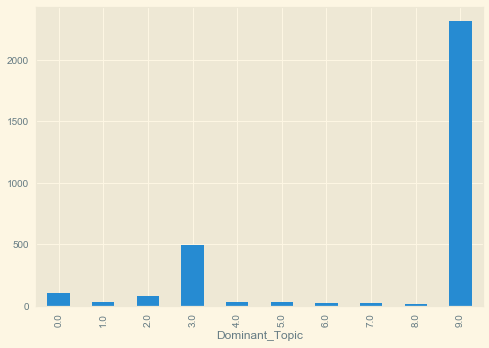

In [111]:
#Find dominant topic for each review
negative_topics = topic_finder(optimal_model,corpus_tfidf, neg_comments)

#Format negative_topics
negative_topics.columns = ['Dominant_Topic', 'Topic%_Contribution','Keywords', 'Reviews']

#View topic Distribution across all documents
negative_topics.groupby('Dominant_Topic')['Dominant_Topic'].count().plot(kind = 'bar')

**Extract 3 most representative documents for each topic**

In [112]:
#Subset largest Topic%_Contribution by Dominant_Topic and capture index
top_docs = negative_topics.groupby('Dominant_Topic')['Topic%_Contribution'].nlargest(3).reset_index()
rows = list(top_docs['level_1'])

#Extract rows
negative_topics.iloc[(rows)]

,Dominant_Topic,Topic%_Contribution,Keywords,Reviews
3093,0.0,0.7821,"well, great_location, incredible, price, location, place, amazing, convenient_location, hassle, budget","it's literally an escape home for rebellious youth, who had a fight with their parents ran away but had to find place to stay"
3018,0.0,0.7792,"well, great_location, incredible, price, location, place, amazing, convenient_location, hassle, budget",Won’t be staying here again. Bed sheets were dirty.
3076,0.0,0.7604,"well, great_location, incredible, price, location, place, amazing, convenient_location, hassle, budget",couldn't imagine a better place to spend the weekend in SF
2939,1.0,0.7319,"place, crash, bad, dirty, cool, stay, fantastic, advertise, care, name","We stayed in this modern little studio for 3 days. The location is good since it is close to the Golden Gate Park, bus stop and restaurants. We loved the decoration but there was a couple of issues, or let say some items missing. No microwave, no toaster and only one stool without table to have lunch. Also one of the window didn’t have any curtains. The dogs are not nasty, but they could be intimidating for some persons."
600,1.0,0.6838,"place, crash, bad, dirty, cool, stay, fantastic, advertise, care, name",Good location. Bad WiFi. Dirty rooms. Very expensive.
3061,1.0,0.6772,"place, crash, bad, dirty, cool, stay, fantastic, advertise, care, name",affordable for three people. Sort of weird with no common space so plan to only sleep there
3063,2.0,0.7577,"good, great, describe, ready, stay, better, worry, neighborhood, exactly, complain",always an amazing experience! The location could not be better! Fantastic communication Incredible views of the bay bridge!!
3119,2.0,0.7514,"good, great, describe, ready, stay, better, worry, neighborhood, exactly, complain",sorry but I have to mention that there was a horrible smell at house since the moment we entered . We thought it will disappear so waited before coming back at night but it was sharper this time. Really really unacceptable from my end if you are hosting guests and guys I cant believe you even dont recognize maybe you are get used to . Maybe it will be better to check the AC or learn the source of problem as due to that I lost all my trust in overall cleanliness at home . and all other thin...
3081,2.0,0.7477,"good, great, describe, ready, stay, better, worry, neighborhood, exactly, complain",good stay everything was as described! no complains whatsoever
2872,3.0,0.8421,"parking, close, street, great, block, restaurant, location, convenient, car, park",We found the location very good for access to the GGB Bay Area and other attractions. We did have a car though which made access easy. Th host advised there was free parking in side streets but we couldn't find any during the day. Some nights we have to work a block or two from our car. Reconsider this place if you are driving. I found parking a big issues. The Wifi is terrible and the hosts only advice was to leave the room. There isn't a comfortable common area to do this. For the price ...
